# 0 : Environment_Setup

### 0.1 : Load_packages

In [1]:
!pip install urllib2 --user

ERROR: Could not find a version that satisfies the requirement urllib2 (from versions: none)
ERROR: No matching distribution found for urllib2


In [1]:
!pip install IMDbPY BeautifulSoup4  --user

In [165]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

from abc import ABCMeta, abstractmethod
from scipy.spatial.distance import squareform
#from scipy.cluster.hierarchy import ward
from scipy.cluster.hierarchy import  linkage
from scipy.cluster.hierarchy import fcluster

In [2]:
pd.set_option('display.max_rows', 1000)


### 0.2 : Connection to Snowflake

In [3]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.upper()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


# 1 : Data Load

In [4]:
power_df=run_query('''
select distinct TITLE_ID, MAX(FIRST_VIEWS_7) AS  ACQUIRING_POWER
from max_dev.workspace.forecasting_fv_summary where country_iso_code = 'US'
GROUP BY 1
''')

In [5]:
input_master=run_query('''select * from  max_prod.DATASCIENCE.MAX_AUDIENCE_OVERLAP_FILTERED_ENDPOINT where dt = '2022-07-24' ''')

# input_june=run_query('''select * from  max_prod.DATASCIENCE.MAX_AUDIENCE_OVERLAP_FILTERED_ENDPOINT where dt = '2022-06-26' ''')

# input_may=run_query('''select * from  max_prod.DATASCIENCE.MAX_AUDIENCE_OVERLAP_FILTERED_ENDPOINT where dt = '2022-05-29' ''')

# input_april=run_query('''select * from  max_prod.DATASCIENCE.MAX_AUDIENCE_OVERLAP_FILTERED_ENDPOINT where dt = '2022-04-17' ''')

# input_index=run_query('''
# select * from max_prod.datascience_stage.AUDIENCE_OVERLAP_CONSOLIDATED_IDS 
# ''')


In [6]:
input_master.head()

,SCORE,INDEX_1,CONSOLIDATED_TITLE_1,LEVEL_1_CATG_NAME_1,CONSOLIDATED_ID_1,INDEX_2,CONSOLIDATED_TITLE_2,LEVEL_1_CATG_NAME_2,CONSOLIDATED_ID_2,DT
0,1.000000,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2022-07-24
1,0.840522,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,1,friends,series,GXdbR_gOXWJuAuwEAACVH,2022-07-24
2,0.794355,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,2022-07-24
3,0.679112,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,2022-07-24
4,0.203899,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,2022-07-24


In [7]:
input_index=input_master.sort_values(by = ['INDEX_1'])[['INDEX_1','CONSOLIDATED_TITLE_1','LEVEL_1_CATG_NAME_1', 'CONSOLIDATED_ID_1']].drop_duplicates()

In [8]:
input_index=input_index.rename({'CONSOLIDATED_TITLE_1':'CONSOLIDATED_TITLE','LEVEL_1_CATG_NAME_1':'LEVEL_1_CATG_NAME','INDEX_1':'INDEX', 'CONSOLIDATED_ID_1':'CONSOLIDATED_ID'},axis=1)

In [9]:
input_index['CONSOLIDATED_TITLE']=input_index.CONSOLIDATED_TITLE.str.replace('$','')

In [10]:
input_index.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID
0,0,euphoria,series,GXKN_xQX5csPDwwEAAABj
1880,1,friends,series,GXdbR_gOXWJuAuwEAACVH
3015,2,game of thrones,series,GVU2cggagzYNJjhsJATwo
4137,3,south park,series,GXr7SEgRi2sLCAAEAAAQu
5273,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH


In [11]:
input_index.shape

(1129, 4)

In [12]:
power_df.shape

(6229, 2)

In [13]:
power_df[power_df['TITLE_ID'] == 'GXKN_xQX5csPDwwEAAABj']

,TITLE_ID,ACQUIRING_POWER
263,GXKN_xQX5csPDwwEAAABj,306201.0


In [14]:
# from sklearn.preprocessing import quantile_transform

# power_df['title']=power_df['INDEX'].str.lower()
# power_df['ACQUIRING_POWER_std']= quantile_transform(power_df['ACQUIRING_POWER'].values.reshape(-1, 1), n_quantiles=100, random_state=0, copy=True).ravel()
# power_df['RETENTION_POWER_std']= quantile_transform(power_df['RETENTION_POWER'].values.reshape(-1, 1), n_quantiles=100, random_state=0, copy=True).ravel()
all_index=input_index.merge(power_df.drop_duplicates(subset = ["TITLE_ID"]),left_on='CONSOLIDATED_ID',right_on='TITLE_ID',how='left')

# 2 : Data Processing

In [15]:
# Turn input row-based table into a pivoted, square matrix
audience_overlap = pd.pivot_table(
    input_master, 
    values='SCORE', 
    index=['INDEX_1'], 
    columns=['INDEX_2'], 
    aggfunc=np.sum
)
audience_overlap = audience_overlap.reset_index()
audience_overlap = audience_overlap.set_index('INDEX_1')

In [16]:
audience_overlap.iloc[0:3, 0:3]

INDEX_2,0,1,2
INDEX_1,,,
0,1.000000,0.840522,0.794355
1,0.840522,1.000000,0.819806
2,0.794355,0.819806,1.000000


In [17]:
audience_overlap.shape

(1129, 1129)

In [18]:
# Calculating the distance matrix from similarity score
# i.e., higher similarity = smaller distance

distance_matrix = 1 - audience_overlap.iloc[:, :]

In [19]:
# convert the redundant n*n square matrix form into a condensed nC2 array
# distance_matrix[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j
distance_matrix = squareform(distance_matrix)

In [20]:
len(distance_matrix)

636756

# 3 : Clustering

In [21]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

In [22]:
# Clusters have been defined by an elbow curve approach and also silhouette to confirm
z = linkage(distance_matrix, method='ward', optimal_ordering=True)

In [23]:
len(input_index)

1129

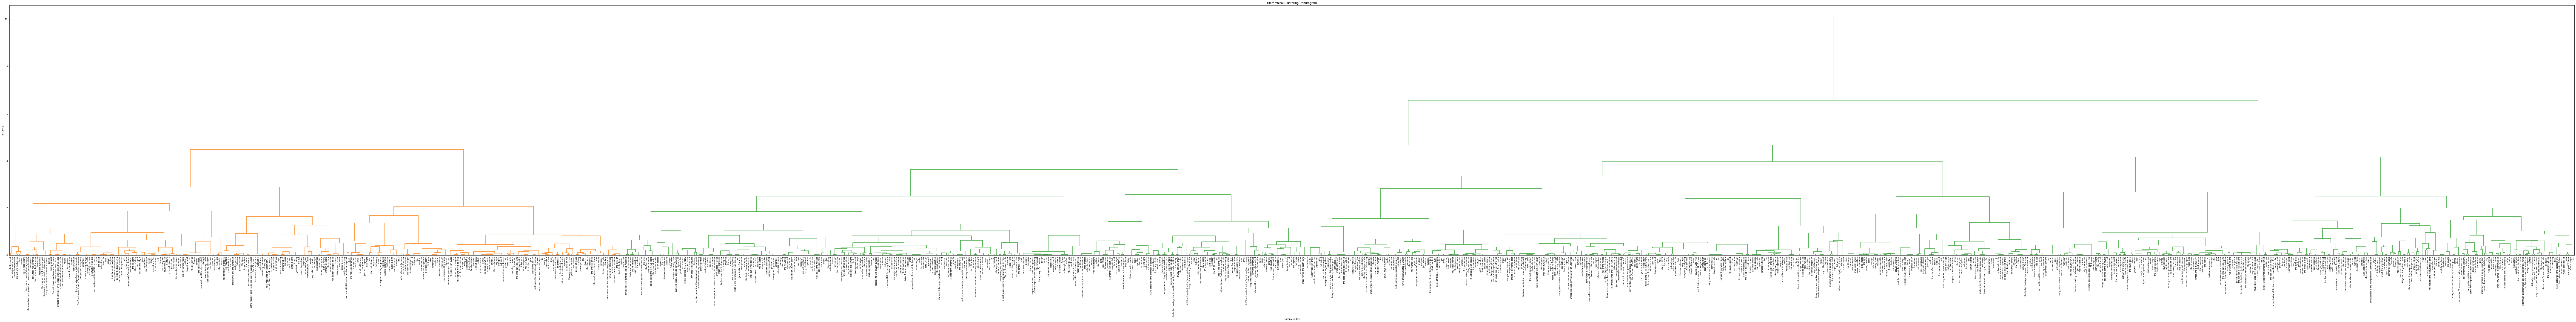

In [144]:
debug: bool = True
    
if debug:

 
    plt.figure(figsize=(200, 20))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    hierarchy.dendrogram(
        z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels=input_index.CONSOLIDATED_TITLE.values
    )
    plt.margins(x=0, y=-0.25)
    plt.savefig('dendrogram.pdf')
    plt.show()

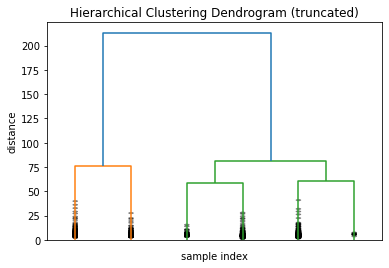

In [70]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(
    z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

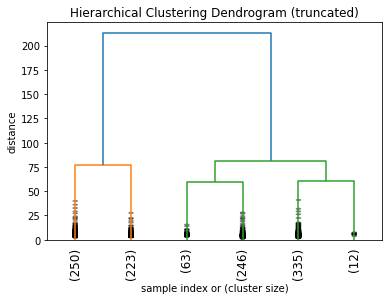

In [71]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

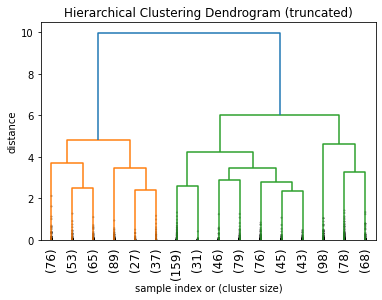

In [35]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

fancy_dendrogram(
    z,
    truncate_mode='lastp',
    p=16,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

1, substract each cluster with the top 20 most popular titles
2, remove trailers and unknown ones
3, filter the titles before clustering ( remove trailers and unknown; top 80% performer;)

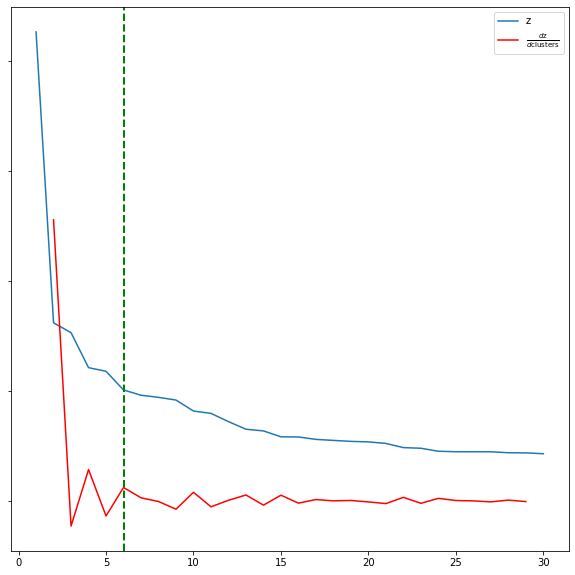

In [72]:
# Quick look at the eblow curve

last = z[-30:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.plot(idxs, last_rev, label='z')
ax.plot(idxs[:-2] + 1, acceleration_rev, color='red', label=r'$\frac{d\mathrm{z}}{d\mathrm{clusters}}$')
ax.set_yticklabels([])

leg = plt.legend(loc=0)

ax.axvline(6, ls='--', color='green', lw=2)
# ax.text(16.5, 5.5, 'k=16', {'size': 15})

In [286]:
# # ################## Example ################
# ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
#                    400., 754., 564., 138., 219., 869., 669.])
# Z = hierarchy.linkage(ytdist, 'single')
# plt.figure()
# dn = hierarchy.dendrogram(Z)

# rootnode, nodelist = hierarchy.to_tree(Z, rd=True)
# index_len = 6
# index = [i for i in range(index_len)]
# group_len = rootnode.id

# group_elements = [[] for i in range(group_len+1)]

# for i in range(group_len+1):
#     if i < index_len:
#         group_elements[i] = [index[i]]
#     else:
#         e = i - index_len
#         group1 = int(Z[e][0])
#         group2 = int(Z[e][1])
#         group_elements[i] = group_elements[group1]+group_elements[group2]

In [32]:
rootnode, nodelist = hierarchy.to_tree(z, rd=True)

index_len = len(input_index)
index = list(input_index.INDEX.unique())
group_len = rootnode.id

group_elements = [[] for i in range(group_len+1)]

for i in range(group_len+1):
    if i < index_len:
        group_elements[i] = [index[i]]
    else:
        e = i - index_len
        group1 = int(z[e][0])
        group2 = int(z[e][1])
        group_elements[i] = group_elements[group1]+group_elements[group2]

In [36]:
input_index[input_index['CONSOLIDATED_TITLE'] == 'cry macho']

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID
178004,157,cry macho,movies,GYSbJuAuzchDCwgEAAAAC


In [37]:
my_dict = input_index.set_index('INDEX')[['CONSOLIDATED_TITLE']].to_dict()['CONSOLIDATED_TITLE']
my_dict[157]

'cry macho'

In [35]:
def index_to_title(index_list):
    return [my_dict.get(i) for i in index_list]

In [34]:
len(group_elements)

2257

In [287]:
def traverse_tree(node, index):
    if index not in group_elements[node.id]:
        return
    if not node.left and not node.right:
        print (node.id)
        return
    traverse_tree(node.left, index)
    traverse_tree(node.right, index)
    print (group_elements[node.id])
        
traverse_tree(rootnode, 0)   

0
[219, 158, 0]
[169, 499, 219, 158, 0]
[502, 320, 546, 169, 499, 219, 158, 0]
[584, 282, 305, 106, 139, 35, 390, 502, 320, 546, 169, 499, 219, 158, 0]
[584, 282, 305, 106, 139, 35, 390, 502, 320, 546, 169, 499, 219, 158, 0, 247, 1, 55, 274, 152, 489, 65, 100, 102, 343, 31, 279, 437, 13]
[584, 282, 305, 106, 139, 35, 390, 502, 320, 546, 169, 499, 219, 158, 0, 247, 1, 55, 274, 152, 489, 65, 100, 102, 343, 31, 279, 437, 13, 908, 1030, 1077, 822, 735, 641, 830, 482, 373, 212, 474, 53, 689, 757, 987, 765, 703, 892, 748, 1072, 864, 808, 1078, 789, 1015, 1022, 625, 1114, 1054, 681, 1043, 276, 435, 559, 950, 1068, 407, 741, 1075, 1038, 810, 804, 939, 478, 316, 243, 778, 577, 427, 783, 485, 631, 737, 917, 108, 192, 310, 149, 481, 667, 327, 1059, 486, 293, 286, 459, 575, 456, 612, 417, 522, 680, 690, 715, 905, 875]
[584, 282, 305, 106, 139, 35, 390, 502, 320, 546, 169, 499, 219, 158, 0, 247, 1, 55, 274, 152, 489, 65, 100, 102, 343, 31, 279, 437, 13, 908, 1030, 1077, 822, 735, 641, 830, 482, 373

In [122]:
result[result['INDEX'] == 157]

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,TITLE_ID,ACQUIRING_POWER,CLUSTER,title
157,157,cry macho,movies,GYSbJuAuzchDCwgEAAAAC,GYSbJuAuzchDCwgEAAAAC,50070.0,9,cry macho


In [92]:
result[(result['CONSOLIDATED_TITLE'] == 'the big bang theory')
      |(result['CONSOLIDATED_TITLE'] == 'space jam: a new legacy')]

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,TITLE_ID,ACQUIRING_POWER,CLUSTER,title
5,5,the big bang theory,series,GXdRsewUPO5uAuwEAABEI,GXdRsewUPO5uAuwEAABEI,76839.0,5,the big bang theory
23,23,space jam: a new legacy,movies,GYOSUnARCGWWmcAEAAAAC,GYOSUnARCGWWmcAEAAAAC,332318.0,4,space jam: a new legacy


In [58]:
for i in group_elements:
    if 0 in i:
        print (i)
        print (index_to_title(i))

[0]
['euphoria']
[226, 158, 0]
['euphoria special episode part 2: jules', 'euphoria special episode part 1: rue', 'euphoria']
[170, 656, 226, 158, 0]
['the fallout', 'unpregnant', 'euphoria special episode part 2: jules', 'euphoria special episode part 1: rue', 'euphoria']
[659, 343, 792, 170, 656, 226, 158, 0]
['betty', 'genera+ion', 'we are who we are', 'the fallout', 'unpregnant', 'euphoria special episode part 2: jules', 'euphoria special episode part 1: rue', 'euphoria']
[903, 300, 327, 106, 139, 35, 451, 659, 343, 792, 170, 656, 226, 158, 0]
['house of ho', 'fboy island', 'girls', 'the sex lives of college girls', 'love life', 'insecure', 'i may destroy you', 'betty', 'genera+ion', 'we are who we are', 'the fallout', 'unpregnant', 'euphoria special episode part 2: jules', 'euphoria special episode part 1: rue', 'euphoria']
[903, 300, 327, 106, 139, 35, 451, 659, 343, 792, 170, 656, 226, 158, 0, 258, 1, 55, 288, 152, 628, 65, 100, 102, 374, 31, 294, 526, 13]
['house of ho', 'fboy 

In [45]:
level_1_l = rootnode.left
level_1_r = rootnode.right

In [94]:
23 in group_elements[level_1_r.id]

True

In [47]:
level_2_rl = level_1_r.left
level_2_rr = level_1_r.right

In [121]:
23 in group_elements[level_2_rr.id]

False

In [126]:
level_3_rrl = level_2_rr.left
level_3_rrr = level_2_rr.right
level_3_rll = level_2_rl.left
level_3_rlr = level_2_rl.right

level_4_rrrr = level_3_rrr.left
level_4_rrrl = level_3_rrr.right
level_4_rlrl = level_3_rlr.left
level_4_rlrr = level_3_rlr.right

level_5_rlrrl = level_4_rlrr.left
level_5_rlrrr = level_4_rlrr.right
level_5_rlrll = level_4_rlrl.left
level_5_rlrlr = level_4_rlrl.right

In [125]:
23 in group_elements[level_4_rlrl.id]

True

In [53]:
result.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,TITLE_ID,ACQUIRING_POWER,CLUSTER,title
0,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,GXKN_xQX5csPDwwEAAABj,306201.0,9,euphoria
1,1,friends,series,GXdbR_gOXWJuAuwEAACVH,GXdbR_gOXWJuAuwEAACVH,110952.0,9,friends
2,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,GVU2cggagzYNJjhsJATwo,44859.0,8,game of thrones
3,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,GXr7SEgRi2sLCAAEAAAQu,73720.0,8,south park
4,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,GVU2cCgUFTYNJjhsJATuH,43642.0,1,last week tonight with john oliver


In [127]:
result.loc[result['INDEX'].isin(group_elements[level_5_rlrll.id]), 'CLUSTER'] = 12
result.loc[result['INDEX'].isin(group_elements[level_5_rlrlr.id]), 'CLUSTER'] = 13

In [128]:
result.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,TITLE_ID,ACQUIRING_POWER,CLUSTER,title
0,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,GXKN_xQX5csPDwwEAAABj,306201.0,6,euphoria
1,1,friends,series,GXdbR_gOXWJuAuwEAACVH,GXdbR_gOXWJuAuwEAACVH,110952.0,6,friends
2,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,GVU2cggagzYNJjhsJATwo,44859.0,3,game of thrones
3,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,GXr7SEgRi2sLCAAEAAAQu,73720.0,10,south park
4,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,GVU2cCgUFTYNJjhsJATuH,43642.0,1,last week tonight with john oliver


In [130]:
result[result['CONSOLIDATED_TITLE'] == 'space jam: a new legacy']

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,TITLE_ID,ACQUIRING_POWER,CLUSTER,title
23,23,space jam: a new legacy,movies,GYOSUnARCGWWmcAEAAAAC,GYOSUnARCGWWmcAEAAAAC,332318.0,13,space jam: a new legacy


# Clustering Results

In [68]:
number_of_clusters = 7

In [69]:
# Generating results for K number of clusters
clusters = fcluster(z, number_of_clusters, criterion='maxclust')

In [70]:
result = all_index.copy()
result['CLUSTER'] = clusters
result['title'] = result['CONSOLIDATED_TITLE']

In [27]:
# result.groupby('CLUSTER').agg({'ACQUIRING_POWER':'mean','RETENTION_POWER':'mean'})

In [29]:
# title_list=['cry macho', 'friends', 'sex and the city', 'south park', 'the big bang theory', 'sesame street', 'game of thrones', 'the matrix: resurrections'
#            , 'euphoria', 'search party']

In [161]:
result.sort_values(by=['CLUSTER','ACQUIRING_POWER'], ascending = False).groupby('CLUSTER').head(1).reset_index(drop=True).reset_index()

,index,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,TITLE_ID,ACQUIRING_POWER,CLUSTER,title
0,0,23,space jam: a new legacy,movies,GYOSUnARCGWWmcAEAAAAC,GYOSUnARCGWWmcAEAAAAC,332318.0,9,space jam: a new legacy
1,1,45,tom & jerry,movies,GYEb9QwLgFF9_ZwEAAAA7,GYEb9QwLgFF9_ZwEAAAA7,218397.0,8,tom & jerry
2,2,10,the suicide squad,movies,GYOxtow3Wz8PDwgEAAAdw,GYOxtow3Wz8PDwgEAAAdw,238975.0,7,the suicide squad
3,3,5,the big bang theory,series,GXdRsewUPO5uAuwEAABEI,GXdRsewUPO5uAuwEAABEI,76839.0,6,the big bang theory
4,4,32,the little things,movies,GYA79hQZbUsI3gQEAAAB0,GYA79hQZbUsI3gQEAAAB0,169231.0,5,the little things
5,5,128,in the heights,movies,GYK0x7gXCza4OwwEAAADl,GYK0x7gXCza4OwwEAAADl,50097.0,4,in the heights
6,6,55,friends: the reunion,special,GYJxCDACcN8PDewEAAAAG,GYJxCDACcN8PDewEAAAAG,372459.0,3,friends: the reunion
7,7,7,godzilla vs. kong,movies,GYFEzmwNES16GkQEAAAAC,GYFEzmwNES16GkQEAAAAC,1063627.0,2,godzilla vs. kong
8,8,44,hard knocks,series,GYPWlwAC-jquLKAEAAADZ,GYPWlwAC-jquLKAEAAADZ,26533.0,1,hard knocks
9,9,15,dune,movies,GYUjdLgBiJp5otAEAAAAJ,GYUjdLgBiJp5otAEAAAAJ,204074.0,0,dune


In [159]:
result_cluster = result.sort_values(by=['CLUSTER','ACQUIRING_POWER']).groupby('CLUSTER').head(1).reset_index(drop=True).reset_index()
cluster_dict = result_cluster[['index', 'CLUSTER']].set_index('CLUSTER').to_dict()['index']
result = result.replace({'CLUSTER':cluster_dict})

In [162]:
result.to_csv('clustering_results.csv')

In [31]:
result[result['CONSOLIDATED_TITLE'].str.contains('cry macho')]

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,TITLE_ID,ACQUIRING_POWER,CLUSTER,title
157,157,cry macho,movies,GYSbJuAuzchDCwgEAAAAC,GYSbJuAuzchDCwgEAAAAC,50070.0,7,cry macho


In [163]:
z

array([[3.52000000e+02, 1.12000000e+03, 9.99999997e-08, 2.00000000e+00],
       [9.55000000e+02, 1.05100000e+03, 9.99999997e-08, 2.00000000e+00],
       [7.59000000e+02, 7.51000000e+02, 9.99999997e-08, 2.00000000e+00],
       ...,
       [2.25000000e+03, 2.25100000e+03, 4.66503737e+00, 6.20000000e+02],
       [2.25400000e+03, 2.25200000e+03, 6.56776500e+00, 8.60000000e+02],
       [2.25300000e+03, 2.25500000e+03, 1.00895474e+01, 1.12900000e+03]])

In [164]:
with open('test.npy', 'wb') as f:
    np.save(f, z)

# 4: Cluster Results Analysis

In [75]:
from bs4 import BeautifulSoup
import imdb
import urllib.request  as urllib2 

In [76]:
def get_movie_id(name):
    ia = imdb.IMDb()
    # searching the name 
    search = ia.search_movie(name)
    # loop for printing the name and id
    for i in range(len(search)):
        # getting the id
        id = search[i].movieID
        # printing it
        print(search[i]['title'] + " : " + id )
        return id

In [77]:
get_movie_id('The Matrix Resurrections')

The Matrix Resurrections : 10838180


'10838180'

In [78]:
access = imdb.IMDb()
movie = access.get_movie('10838180')#.data
print("Cover url: %s" % movie['full-size cover url'])
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= movie['full-size cover url'],width=300, height=300)

Cover url: https://m.media-amazon.com/images/M/MV5BMGJkNDJlZWUtOGM1Ny00YjNkLThiM2QtY2ZjMzQxMTIxNWNmXkEyXkFqcGdeQXVyMDM2NDM2MQ@@.jpg


In [79]:
# from IPython.display import HTML, display
# imgurl=movie['full-size cover url']
# display(HTML(f'''<table><tr><td><img src={imgurl} width='20%'></td><td><img src={imgurl} width='20%'></td></tr></table>'''))

In [170]:
from IPython.display import HTML, display,IFrame
import imdb
import urllib.request  as urllib2 

access = imdb.IMDb()
num_titles = 15

topmovies_df=result.drop_duplicates(subset='title').sort_values(by=['CLUSTER','ACQUIRING_POWER'], ascending=False).groupby('CLUSTER').head(num_titles)
topmovies_df.head()
htmlstr=f'''<table>'''
n=num_titles
for index, row in topmovies_df.iterrows():    
    if (n>0):
        if (n==num_titles):
            htmlstr=htmlstr+'<tr>'
        try:
            movie_id=get_movie_id(row['title'])
            cluster_id=row['CLUSTER']
            movie = access.get_movie(movie_id)
            imgurl=movie['full-size cover url']
            htmlstr=htmlstr+f'''<td><img src={imgurl} width="120""></td>'''
        except:
            htmlstr=htmlstr+f'''<td>Missing</td>'''
        #print(row['title'], row['CLUSTER'])
        if (n==1):
            htmlstr=htmlstr+'</tr>'
            n=num_titles
        else:
            n=n-1  
htmlstr=htmlstr+'</table>'

Space Jam: A New Legacy : 3554046
The Conjuring: The Devil Made Me Do It : 7069210
Charm City Kings : 9048840
The Fresh Prince of Bel-Air Reunion : 13315308
Judas and the Black Messiah : 9784798
King Richard : 9620288
Malignant : 3811906
The Fresh Prince of Bel-Air : 0098800
Ready or Not : 7798634
The Forever Purge : 10327252
The Nun : 5814060
Halloween Kills : 10665338
Old : 10954652
It Chapter Two : 7349950
Freaky : 10919380
Tom & Jerry : 1361336
The Witches by Roald Dahl (2021) (Podcast Episode) - The Drunk Guys Book Club Podcast : 18793996
Looney Tunes Cartoons : 8543208
Looney Tunes Cartoons : 8543208
Scoob! : 3152592
8-Bit Christmas : 11540284
Good Boys : 6977338
Stuber : 7734218
Ted : 1637725
Get Hard : 2561572
Dolittle : 6673612
Ron's Gone Wrong : 7504818
The House : 11703050
Spies in Disguise : 5814534
Identity Thief : 2024432
The Suicide Squad : 6334354
Peacemaker : 13146488
Doctor Who : 0436992
Titans : 1043813
Doom Patrol : 8416494
Batwoman : 8712204
Harley Quinn : 7658402


In [168]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [169]:

from IPython.display import HTML, display,IFrame
display(HTML(htmlstr))

,,,,,,,,,,,,,,
,Missing,,,,,,,,,,,,,
,,,,,,,,,,,,,,
,,,,,,,,,,,,,,
,,,,,,,,,,,,,,
,,,,,,,,,,,,,,
,,,,Missing,,,,Missing,,,,,,
,,,,Missing,,,,,,Missing,,,,
,,,,Missing,,,,,,,,,,
,,,,,,,,,,,,,,


In [111]:
topmovies_df

,INDEX_x,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,INDEX_y,ACQUIRING_POWER,RETENTION_POWER,title,ACQUIRING_POWER_std,RETENTION_POWER_std,CLUSTER
1,1,friends,series,GXdbR_gOXWJuAuwEAACVH,Friends,6.679881,20.532381,friends,0.995558,1.000000,4
31,31,sex and the city,series,GVU2cAAPSJoNJjhsJATt6,Sex and the City,1.562007,2.453214,sex and the city,0.991032,0.990955,4
13,13,and just like that...,series,GYYxBtQFFnmbDBwEAAAAE,And Just Like That...,1.474509,0.449452,and just like that...,0.990954,0.989952,4
65,65,pretty little liars,series,GXdMTbQrnTaXCPQEAAA9W,Pretty Little Liars,1.094109,1.150812,pretty little liars,0.990618,0.990303,4
35,35,insecure,series,GV7xdwg1cosPDWwEAAABT,Insecure,0.790137,0.383920,insecure,0.990349,0.989919,4
3,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,South Park,11.702366,18.100831,south park,1.000000,0.998783,3
5,5,the big bang theory,series,GXdRsewUPO5uAuwEAABEI,The Big Bang Theory,3.804851,14.963670,the big bang theory,0.993015,0.997214,3
64,64,looney tunes,series,GXozhGwOz77DCYwEAABBA,Looney Tunes,1.810236,2.552176,looney tunes,0.991251,0.991004,3
10,10,the suicide squad,movies,GYOxtow3Wz8PDwgEAAAdw,The Suicide Squad,1.637846,0.807640,the suicide squad,0.991099,0.990131,3
99,99,sesame street,series,GXouLWwp8MsPDIgEAAAqT,Sesame Street,1.247490,2.881494,sesame street,0.990753,0.991169,3


In [113]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'
fig = px.scatter(result,x='ACQUIRING_POWER_std', y='RETENTION_POWER_std',color='CLUSTER', hover_name='title', title="CONSOLIDATED_TITLE", width=800, height=640)
fig.update_layout(xaxis_title="ACQUIRING_POWER_std", yaxis_title="RETENTION_POWER_std")
fig.show()

# 5 : Cluster Assignment for rest of the shows

In [ ]:
# These outputs are generated by the audience overlap model suite

input_master_full_table = f'../Audience_Overlap/{overlap_output_date}_audience_overlap_endpoint_table_max{long_tail}.csv'
input_index_full_table = f'../Audience_Overlap/{overlap_output_date}_audience_overlap_id_mapping_table_output_max{long_tail}.csv'

input_master_full = pd.read_csv(input_master_full_table)
input_index_full = pd.read_csv(input_index_full_table)

In [ ]:
audience_overlap_all_titles = pd.pivot_table(
    input_master_full, 
    values='SCORE', 
    index=['INDEX_1'],
    columns=['INDEX_2'], 
    aggfunc=np.sum
)
audience_overlap_all_titles = audience_overlap_all_titles.reset_index()
audience_overlap_all_titles = audience_overlap_all_titles.set_index('INDEX_1')

In [ ]:
audience_overlap_all_titles.iloc[0:3, 0:3]

In [ ]:
distance_matrix_all_titles = 1 - audience_overlap_all_titles.iloc[:, :]

In [ ]:
cluster_list = result['CLUSTER'].unique()
print(f'Cluster list: {cluster_list}')

count = 0
cluster_assignment = {}
temp_dict = {}
verbose = False

for i in range(audience_overlap_all_titles.shape[0]):

    if i not in result_map:
        
        # Calculate distance to each cluster
        for cluster_number in cluster_list:
            
            cluster_members_index = result[result.CLUSTER == cluster_number]['INDEX'].tolist()
            distance = [float(distance_matrix_all_titles[i][index]) for index in cluster_members_index]
            
            # Average distance (similarity) to the cluster members
            temp_dict[cluster_number] = sum(distance) / (1.0*len(distance))
            
        cluster_assignment[i] = min(temp_dict.keys(), key=(lambda k: temp_dict[k]))
        if verbose:
            print(f'Cluster with minimum distance: {cluster_assignment[i]}')
        
        count += 1
    else:
        cluster_assignment[i] = result_map[i]
print(f'Number of titles given a cluster assignment: {count}')

In [ ]:
scoring_df = pd.DataFrame(cluster_assignment.items(), columns=['INDEX', 'CLUSTER'])
assignments = input_index_full.merge(scoring_df, on='INDEX', how='inner')
assignments = (
        assignments.rename(columns={
        'CONSOLIDATED_TITLE': 'title',
        'LEVEL_1_CATG_NAME': 'title_type',
        'CLUSTER': 'cluster_number'
    })
    [['title', 'title_type', 'cluster_number']]
)

In [ ]:
assignments[
    assignments['cluster_number'] == assignments[assignments['title'] == 'leaving neverland']['cluster_number'].values[0]
    ].head(50)

In [ ]:
pd.set_option('max_colwidth', 400)

In [ ]:
pd.DataFrame(
    assignments[['cluster_number', 'title']].groupby(['cluster_number']).apply(lambda x: ', '.join(x['title'].values[:4]))
)

In [ ]:
assignments.groupby(['cluster_number', 'title_type']).count()

In [ ]:
assignments.shape

# Clustering Results Analysis

In [169]:
result.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,TITLE_ID,ACQUIRING_POWER,CLUSTER,title
0,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,GXKN_xQX5csPDwwEAAABj,306205.0,2,euphoria
1,1,friends,series,GXdbR_gOXWJuAuwEAACVH,GXdbR_gOXWJuAuwEAACVH,110952.0,2,friends
2,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,GVU2cggagzYNJjhsJATwo,44859.0,5,game of thrones
3,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,GXr7SEgRi2sLCAAEAAAQu,73720.0,3,south park
4,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,GVU2cCgUFTYNJjhsJATuH,43642.0,7,last week tonight with john oliver


In [168]:
result['CLUSTER'] = 8-result['CLUSTER']

In [177]:
acquisition = run_query('''
select title_id, title, CUMULATIVE_FIRST_VIEWS, TO_DATE(DATEADD(day, DAYS_ON_HBO_MAX, FIRST_RELEASE_DATE)) AS DATE
from max_prod.content_analytics.new_title_release_days_on_platform
where TITLE_LEVEL = 'Series and Movies'
''')

In [172]:
engagement = run_query('''
select title_id, title, CUMULATIVE_VIEWING_SUBS, TO_DATE(DATEADD(day, DAYS_ON_HBO_MAX, FIRST_RELEASE_DATE)) AS DATE
from max_prod.content_analytics.new_title_release_days_on_platform
where TITLE_LEVEL = 'Series and Movies'
''')

In [179]:
hours = run_query('''
select title_id, title, CUMULATIVE_HOURS, TO_DATE(DATEADD(day, DAYS_ON_HBO_MAX, FIRST_RELEASE_DATE)) AS DATE
from max_prod.content_analytics.new_title_release_days_on_platform
where TITLE_LEVEL = 'Series and Movies'
''')

In [244]:
available_hours = run_query('''
select distinct title_id, title, MAX(TOTAL_RUN_TIME) AS TOTAL_RUN_TIME
from max_prod.content_analytics.new_title_release_days_on_platform
where TITLE_LEVEL = 'Series and Movies'
GROUP BY 1, 2
''')

In [186]:
len(engagement.TITLE_ID.unique())

6299

In [185]:
count = result.groupby(['CLUSTER']).count()['INDEX'].reset_index().rename(columns = {'INDEX':'title_count'})

In [187]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import datetime
from datetime import timedelta
import scipy.stats as st

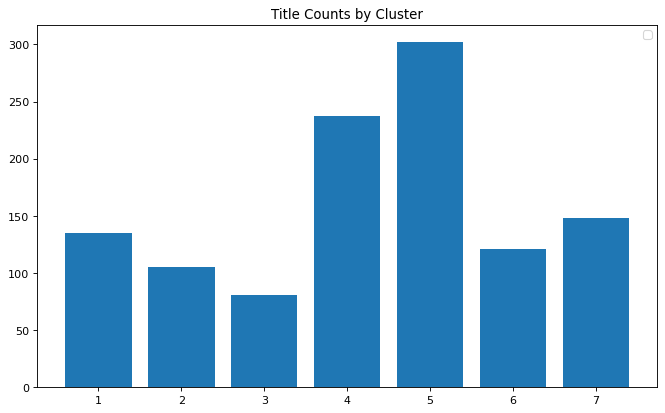

In [194]:
figure(figsize=(10, 6), dpi=80)
plot_df = count.copy()
plt.bar(plot_df['CLUSTER'], plot_df['title_count'],
                linewidth=2, #label = 'Tartget Value@28Day', linestyle='dashed'
       )
# plt.plot(plot_df['CLUSTER'], plot_df['title_count'],
#                 #linewidth=2, label = 'Predicted Value'
#         )
# plt.fill_between(plot_df['CLUSTER'], plot_df['lower_bound'], plot_df['upper_bound'], color='orange', alpha=.1, label = 'Error Bound')
plt.title('Title Counts by Cluster')
# plt.ylim(0, 42)
plt.legend()
plt.show()

In [245]:
available_hours = available_hours.merge(result[['TITLE_ID', 'CLUSTER']], on = 'TITLE_ID')
available_hours_sum = available_hours[['CLUSTER', 'TOTAL_RUN_TIME']].groupby(['CLUSTER']).sum().reset_index()

In [246]:
available_hours.head()

,TITLE_ID,TITLE,TOTAL_RUN_TIME,CLUSTER
0,GYM1BXQbxDWqHwgEAAABv,The Lost World: Jurassic Park,128.600000,5
1,GWd-P2gZGP8IelQEAAADt,The Take,93.250000,5
2,GXodAyAMc37DCYwEAAAPX,X-Men: First Class,131.866667,5
3,GXYVQxgnZcsPCwgEAAAnr,Chocolat,118.333333,2
4,GYKabGAV4LqS1oAEAAABb,Let Him Go,113.850000,1


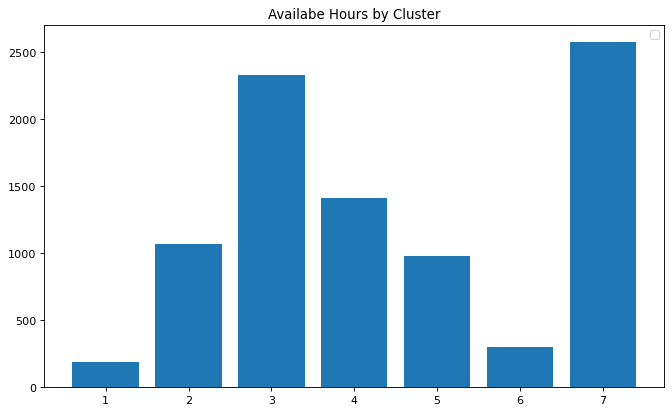

In [248]:
figure(figsize=(10, 6), dpi=80)
plot_df = available_hours_sum.copy()
plt.bar(plot_df['CLUSTER'], plot_df['TOTAL_RUN_TIME']/60,
                linewidth=2, #label = 'Tartget Value@28Day', linestyle='dashed'
       )
# plt.plot(plot_df['CLUSTER'], plot_df['title_count'],
#                 #linewidth=2, label = 'Predicted Value'
#         )
# plt.fill_between(plot_df['CLUSTER'], plot_df['lower_bound'], plot_df['upper_bound'], color='orange', alpha=.1, label = 'Error Bound')
plt.title('Availabe Hours by Cluster')
# plt.ylim(0, 42)
plt.legend()
plt.show()

In [198]:
acquisition = acquisition.merge(result[['TITLE_ID', 'CLUSTER']], on = 'TITLE_ID')
acquisition = acquisition.merge(count, on = ['CLUSTER'])
acquisition['DATE_MONTH'] = pd.to_datetime(acquisition['DATE']).dt.to_period('M').values.astype('datetime64[M]')
acquisition['AVG_FIRST_VIEWS'] = acquisition['CUMULATIVE_FIRST_VIEWS']/acquisition['title_count']
acquisition_sum = acquisition.groupby(['CLUSTER', 'DATE_MONTH']).sum().reset_index()

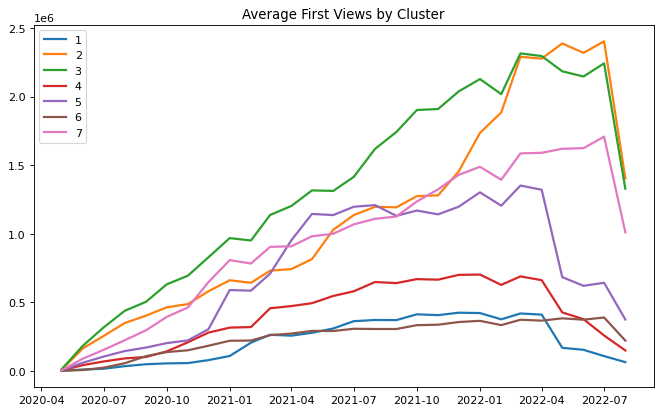

In [230]:
figure(figsize=(10, 6), dpi=80)
for i in range(1, 8):
    plot_df = acquisition_sum[acquisition_sum['CLUSTER'] == i]
    plt.plot(plot_df['DATE_MONTH'], plot_df['AVG_FIRST_VIEWS'],
                    linewidth=2, label = i, #linestyle='dashed'
           )
plt.title('Average First Views by Cluster')
# plt.ylim(0, 42)
plt.legend()
plt.show()

In [250]:
engagement = engagement.merge(result[['TITLE_ID', 'CLUSTER']], on = 'TITLE_ID')
engagement = engagement.merge(count, on = ['CLUSTER'])
engagement['DATE_MONTH'] = pd.to_datetime(engagement['DATE']).dt.to_period('M').values.astype('datetime64[M]')
engagement['AVG_VIEWING_SUBS'] = engagement['CUMULATIVE_VIEWING_SUBS']/engagement['title_count']
engagement_sum = engagement.groupby(['CLUSTER', 'DATE_MONTH']).sum().reset_index()

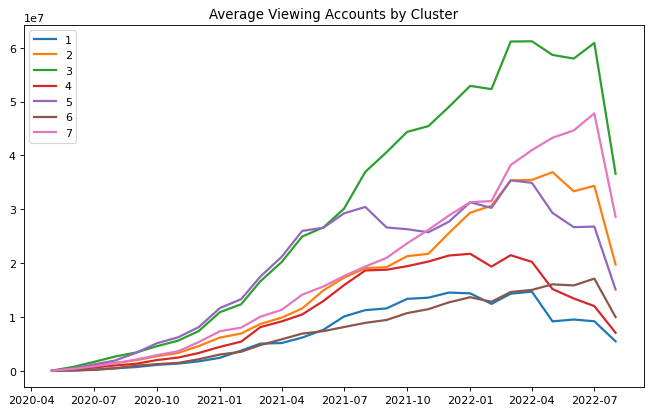

In [256]:
figure(figsize=(10, 6), dpi=80)
for i in range(1, 8):
    plot_df = engagement_sum[engagement_sum['CLUSTER'] == i]
    plt.plot(plot_df['DATE_MONTH'], plot_df['AVG_VIEWING_SUBS'],
                    linewidth=2, label = i, #linestyle='dashed'
           )
plt.title('Average Viewing Accounts by Cluster')
# plt.ylim(0, 42)
plt.legend()
plt.show()

## AOS within Cluster

In [257]:
result.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,TITLE_ID,ACQUIRING_POWER,CLUSTER,title
0,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,GXKN_xQX5csPDwwEAAABj,306205.0,2,euphoria
1,1,friends,series,GXdbR_gOXWJuAuwEAACVH,GXdbR_gOXWJuAuwEAACVH,110952.0,2,friends
2,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,GVU2cggagzYNJjhsJATwo,44859.0,5,game of thrones
3,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,GXr7SEgRi2sLCAAEAAAQu,73720.0,3,south park
4,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,GVU2cCgUFTYNJjhsJATuH,43642.0,7,last week tonight with john oliver


In [258]:
input_master.head()

,SCORE,INDEX_1,CONSOLIDATED_TITLE_1,LEVEL_1_CATG_NAME_1,CONSOLIDATED_ID_1,INDEX_2,CONSOLIDATED_TITLE_2,LEVEL_1_CATG_NAME_2,CONSOLIDATED_ID_2,DT
0,0.188695,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,651,ender's game,movies,GYGazoATo1DzDwwEAAACB,2022-07-24
1,0.569345,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,656,unpregnant,movies,GX1AF4QPcoYaMwgEAAAQ5,2022-07-24
2,0.939043,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,657,rich & shameless,series,GYnG0mQrJsxuLwgEAAADe,2022-07-24
3,0.833340,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,658,the third day,series,GXx9sDwE-Ta0MlAEAAACQ,2022-07-24
4,0.571744,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,659,betty,series,GXnt7fw7qNVSpjQEAAAJx,2022-07-24


In [134]:
cluster_aos = input_master[['SCORE', 'CONSOLIDATED_ID_1', 'CONSOLIDATED_ID_2']].copy()

In [135]:
cluster_aos= cluster_aos.merge(result[['CONSOLIDATED_ID', 'CLUSTER']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_1', 'CLUSTER':'CLUSTER_1'}),
                                           on = ['CONSOLIDATED_ID_1'])
cluster_aos= cluster_aos.merge(result[['CONSOLIDATED_ID', 'CLUSTER']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_2', 'CLUSTER':'CLUSTER_2'}),
                                           on = ['CONSOLIDATED_ID_2'])

In [136]:
cluster_aos = cluster_aos[cluster_aos['CLUSTER_1'] == cluster_aos['CLUSTER_2']]

In [137]:
input_master.SCORE.mean()

0.43372961839818164

In [138]:
cluster_aos.groupby(['CLUSTER_1']).mean()

,SCORE,CLUSTER_2
CLUSTER_1,,
1,0.601402,1
2,0.723336,2
3,0.628463,3
6,0.697471,6
8,0.530442,8
9,0.697752,9
10,0.711452,10
11,0.787486,11
12,0.710940,12


# Clustering results from different period

In [10]:
def hierarchical_clustering(input):
    input = input.sort_values(by = ['INDEX_1', 'INDEX_2'])
    audience_overlap = pd.pivot_table(
        input, 
        values='SCORE', 
        index=['INDEX_1'], 
        columns=['INDEX_2'], 
        aggfunc=np.sum
    )
#     audience_overlap = audience_overlap.reset_index()
#     audience_overlap = audience_overlap.set_index('INDEX_1')
    
    distance_matrix = 1 - audience_overlap.iloc[:, :]
    distance_matrix = squareform(distance_matrix)
    
    z = linkage(distance_matrix, method='ward', optimal_ordering=True)
#     clusters = fcluster(z, number_of_clusters, criterion='maxclust')
    
    input_index=input[['INDEX_1','CONSOLIDATED_TITLE_1','LEVEL_1_CATG_NAME_1', 'CONSOLIDATED_ID_1']].drop_duplicates()
    input_index=input_index.rename({'CONSOLIDATED_TITLE_1':'CONSOLIDATED_TITLE','LEVEL_1_CATG_NAME_1':'LEVEL_1_CATG_NAME','INDEX_1':'INDEX', 'CONSOLIDATED_ID_1':'CONSOLIDATED_ID'},axis=1)
#     result_temp = all_index.copy()
#     result_temp['CLUSTER'] = clusters
    return input_index,z

In [31]:
def assign_cluster(number_of_clusters, index, z):
    clusters = fcluster(z, number_of_clusters, criterion='maxclust')
    result = index.copy()
    result['CLUSTER'] = clusters
    return result

In [11]:
index, z = hierarchical_clustering(input_master)
index_june, z_june = hierarchical_clustering(input_june)
index_may, z_may = hierarchical_clustering(input_may)
index_april, z_april = hierarchical_clustering(input_april)

In [12]:
number_of_clusters = 2

In [14]:
result = assign_cluster(number_of_clusters, index, z)
result_june = assign_cluster(number_of_clusters, index_june, z_june)
result_may = assign_cluster(number_of_clusters, index_may, z_may)
result_april = assign_cluster(number_of_clusters, index_april, z_april)

In [17]:
result.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,CLUSTER
135168,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2
136297,1,friends,series,GXdbR_gOXWJuAuwEAACVH,2
137426,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,2
138555,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,2
139684,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,1


In [32]:
result_2 = assign_cluster(2, index, z)
result_3 = assign_cluster(3, index, z)
result_4 = assign_cluster(4, index, z)
result_5 = assign_cluster(5, index, z)

In [38]:
z[-5:]

array([[2246.        , 2243.        ,    4.16291937,  240.        ],
       [2248.        , 2239.        ,    4.48566866,  269.        ],
       [2250.        , 2251.        ,    4.66503737,  620.        ],
       [2254.        , 2252.        ,    6.567765  ,  860.        ],
       [2253.        , 2255.        ,   10.08954744, 1129.        ]])

In [33]:
result_2.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,CLUSTER
135168,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2
136297,1,friends,series,GXdbR_gOXWJuAuwEAACVH,2
137426,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,2
138555,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,2
139684,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,1


In [34]:
result_3.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,CLUSTER
135168,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,3
136297,1,friends,series,GXdbR_gOXWJuAuwEAACVH,3
137426,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,2
138555,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,2
139684,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,1


In [35]:
result_4.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,CLUSTER
135168,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,4
136297,1,friends,series,GXdbR_gOXWJuAuwEAACVH,4
137426,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,2
138555,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,3
139684,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,1


In [36]:
result_5.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,CLUSTER
135168,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,5
136297,1,friends,series,GXdbR_gOXWJuAuwEAACVH,5
137426,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,3
138555,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,4
139684,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,1


In [89]:
def remap_cluster(result):
    cluster_mapping = result.groupby('CLUSTER').ACQUIRING_POWER.mean().reset_index().sort_values(by = ['ACQUIRING_POWER']).reset_index(drop = True)
    cluster_mapping = cluster_mapping[['CLUSTER']].to_dict()
    cluster_mapping = cluster_mapping['CLUSTER']
    result=result.replace({"CLUSTER": cluster_mapping})
    return result

In [90]:
result = remap_cluster(result)
result_june = remap_cluster(result_june)
result_may = remap_cluster(result_may)
result_april = remap_cluster(result_april)

In [95]:
result_june.rename(columns = {'CLUSTER': 'CLUSTER_JUNE'},inplace = True)
result_may.rename(columns = {'CLUSTER': 'CLUSTER_MAY'},inplace = True)
result_april.rename(columns = {'CLUSTER': 'CLUSTER_APRIL'},inplace = True)

In [96]:
result[result['CONSOLIDATED_TITLE'] == 'behind closed doors']

,INDEX_x,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,INDEX_y,ACQUIRING_POWER,RETENTION_POWER,title,ACQUIRING_POWER_std,RETENTION_POWER_std,CLUSTER
0,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,Behind Closed Doors,0.000822,0.000356,behind closed doors,0.329465,0.330334,3
1064,2673,behind closed doors,movies,GXQJfmQq-G8PDWAEAAAA3,Behind Closed Doors,0.000822,0.000356,behind closed doors,0.329465,0.330334,6


In [97]:
# result=result[['CONSOLIDATED_TITLE', 'ACQUIRING_POWER', 'RETENTION_POWER', 'CLUSTER']].drop_duplicates()
# result_june=result_june[['CONSOLIDATED_TITLE', 'ACQUIRING_POWER', 'RETENTION_POWER', 'CLUSTER_JUNE']].drop_duplicates()
# result_may=result_may[['CONSOLIDATED_TITLE', 'ACQUIRING_POWER', 'RETENTION_POWER', 'CLUSTER_MAY']].drop_duplicates()
# result_april=result_april[['CONSOLIDATED_TITLE', 'ACQUIRING_POWER', 'RETENTION_POWER', 'CLUSTER_APRIL']].drop_duplicates()

In [98]:
final_result = result.merge(result_june[['CONSOLIDATED_ID', 'CLUSTER_JUNE']], on = ['CONSOLIDATED_ID'])
final_result = final_result.merge(result_may[['CONSOLIDATED_ID', 'CLUSTER_MAY']], on = ['CONSOLIDATED_ID'])
final_result = final_result.merge(result_april[['CONSOLIDATED_ID', 'CLUSTER_APRIL']], on = ['CONSOLIDATED_ID'])

In [102]:
final_result[final_result['CLUSTER_MAY'] != final_result['CLUSTER_APRIL']][['CONSOLIDATED_TITLE', 'ACQUIRING_POWER', 'RETENTION_POWER', 'CLUSTER', 'CLUSTER_JUNE', 'CLUSTER_MAY', 'CLUSTER_APRIL']]\
.sort_values(by = ['ACQUIRING_POWER'], ascending = False).head(20)

,CONSOLIDATED_TITLE,ACQUIRING_POWER,RETENTION_POWER,CLUSTER,CLUSTER_JUNE,CLUSTER_MAY,CLUSTER_APRIL
136,south park,11.702366,18.100831,4,4,4,6
134,friends,6.679881,20.532381,6,4,4,5
138,the big bang theory,3.804851,14.963670,4,6,6,5
135,game of thrones,3.027507,3.049528,1,6,6,3
403,sex and the city,1.562007,2.453214,6,4,4,5
163,sex and the city,1.562007,2.453214,6,4,4,5
146,and just like that...,1.474509,0.449452,3,4,4,5
156,the matrix: resurrections,1.419992,0.549491,6,6,6,3
141,mortal kombat,1.352604,0.331952,4,6,6,3
155,space jam: a new legacy,1.146357,0.518253,4,2,2,6


In [40]:
input_master.head()

,SCORE,INDEX_1,CONSOLIDATED_TITLE_1,LEVEL_1_CATG_NAME_1,CONSOLIDATED_ID_1,INDEX_2,CONSOLIDATED_TITLE_2,LEVEL_1_CATG_NAME_2,CONSOLIDATED_ID_2,DT
0,0.188695,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,651,ender's game,movies,GYGazoATo1DzDwwEAAACB,2022-07-24
1,0.569345,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,656,unpregnant,movies,GX1AF4QPcoYaMwgEAAAQ5,2022-07-24
2,0.939043,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,657,rich & shameless,series,GYnG0mQrJsxuLwgEAAADe,2022-07-24
3,0.833340,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,658,the third day,series,GXx9sDwE-Ta0MlAEAAACQ,2022-07-24
4,0.571744,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,659,betty,series,GXnt7fw7qNVSpjQEAAAJx,2022-07-24


In [39]:
result.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,CONSOLIDATED_ID,CLUSTER
135168,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,5
136297,1,friends,series,GXdbR_gOXWJuAuwEAACVH,5
137426,2,game of thrones,series,GVU2cggagzYNJjhsJATwo,3
138555,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,4
139684,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,1


In [108]:
input_master = input_master.merge(result[['CONSOLIDATED_ID', 'CLUSTER']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_1', 'CLUSTER':'CLUSTER_1'}), on = ['CONSOLIDATED_ID_1'])\
            .merge(result[['CONSOLIDATED_ID', 'CLUSTER']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_2', 'CLUSTER':'CLUSTER_2'}), on = ['CONSOLIDATED_ID_2'])
input_master.loc[input_master['CLUSTER_1'] == input_master['CLUSTER_2'], 'same_cluster'] = 1
input_master['same_cluster'] = input_master['same_cluster'].fillna(0)

,SCORE,INDEX_1,CONSOLIDATED_TITLE_1,LEVEL_1_CATG_NAME_1,CONSOLIDATED_ID_1,INDEX_2,CONSOLIDATED_TITLE_2,LEVEL_1_CATG_NAME_2,CONSOLIDATED_ID_2,DT,CLUSTER_1,CLUSTER_2,same_cluster
0,0.188695,3115,behind closed doors,series,GX2ETYQ4ijmk7UwEAAAAR,651,ender's game,movies,GYGazoATo1DzDwwEAAACB,2022-07-24,3,1,0.0
1,0.567320,3116,son in law,movies,GXEIDJwK4oo0IvQEAAAF6,651,ender's game,movies,GYGazoATo1DzDwwEAAACB,2022-07-24,3,1,0.0
2,0.708608,3126,big trouble in little china,movies,GXSycVAjjQL29bAEAAA3v,651,ender's game,movies,GYGazoATo1DzDwwEAAACB,2022-07-24,4,1,0.0
3,0.308137,3131,i am evidence,movies,GWjrv1w8rXq6BwgEAAAJd,651,ender's game,movies,GYGazoATo1DzDwwEAAACB,2022-07-24,1,1,1.0
4,0.829976,3134,x-men: apocalypse,movies,GWIeTXwc_o6mywwEAAAF8,651,ender's game,movies,GYGazoATo1DzDwwEAAACB,2022-07-24,6,1,0.0


In [110]:
input_june = input_june.merge(result_june[['CONSOLIDATED_ID', 'CLUSTER_JUNE']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_1', 'CLUSTER_JUNE':'CLUSTER_1'}), on = ['CONSOLIDATED_ID_1'])\
            .merge(result_june[['CONSOLIDATED_ID', 'CLUSTER_JUNE']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_2', 'CLUSTER_JUNE':'CLUSTER_2'}), on = ['CONSOLIDATED_ID_2'])
input_june.loc[input_june['CLUSTER_1'] == input_june['CLUSTER_2'], 'same_cluster'] = 1
input_june['same_cluster'] = input_june['same_cluster'].fillna(0)

input_may = input_may.merge(result_may[['CONSOLIDATED_ID', 'CLUSTER_MAY']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_1', 'CLUSTER_MAY':'CLUSTER_1'}), on = ['CONSOLIDATED_ID_1'])\
            .merge(result_may[['CONSOLIDATED_ID', 'CLUSTER_MAY']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_2', 'CLUSTER_MAY':'CLUSTER_2'}), on = ['CONSOLIDATED_ID_2'])
input_may.loc[input_may['CLUSTER_1'] == input_may['CLUSTER_2'], 'same_cluster'] = 1
input_may['same_cluster'] = input_may['same_cluster'].fillna(0)

input_april = input_april.merge(result_april[['CONSOLIDATED_ID', 'CLUSTER_APRIL']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_1', 'CLUSTER_APRIL':'CLUSTER_1'}), on = ['CONSOLIDATED_ID_1'])\
            .merge(result_april[['CONSOLIDATED_ID', 'CLUSTER_APRIL']].rename(columns = {'CONSOLIDATED_ID':'CONSOLIDATED_ID_2', 'CLUSTER_APRIL':'CLUSTER_2'}), on = ['CONSOLIDATED_ID_2'])
input_april.loc[input_april['CLUSTER_1'] == input_april['CLUSTER_2'], 'same_cluster'] = 1
input_april['same_cluster'] = input_april['same_cluster'].fillna(0)

In [111]:
input_april.head()

,SCORE,INDEX_1,CONSOLIDATED_TITLE_1,LEVEL_1_CATG_NAME_1,CONSOLIDATED_ID_1,INDEX_2,CONSOLIDATED_TITLE_2,LEVEL_1_CATG_NAME_2,CONSOLIDATED_ID_2,DT,CLUSTER_1,CLUSTER_2,same_cluster
0,1.000000,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2022-04-17,5,5,1.0
1,0.794023,1,game of thrones,series,GVU2cggagzYNJjhsJATwo,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2022-04-17,3,5,0.0
2,0.841455,2,friends,series,GXdbR_gOXWJuAuwEAACVH,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2022-04-17,5,5,1.0
3,0.664561,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2022-04-17,6,5,0.0
4,0.205497,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2022-04-17,4,5,0.0


In [114]:
final_input = input_master[['CONSOLIDATED_TITLE_1', 'CONSOLIDATED_ID_1', 'CONSOLIDATED_TITLE_2', 'CONSOLIDATED_ID_2', 'same_cluster']]\
              .merge(input_june[['CONSOLIDATED_ID_1', 'CONSOLIDATED_ID_2', 'same_cluster']].rename(columns = {'same_cluster':'same_cluster_june'}), on = ['CONSOLIDATED_ID_1', 'CONSOLIDATED_ID_2'])\
              .merge(input_may[['CONSOLIDATED_ID_1', 'CONSOLIDATED_ID_2', 'same_cluster']].rename(columns = {'same_cluster':'same_cluster_may'}), on = ['CONSOLIDATED_ID_1', 'CONSOLIDATED_ID_2'])\
              .merge(input_april[['CONSOLIDATED_ID_1', 'CONSOLIDATED_ID_2', 'same_cluster']].rename(columns = {'same_cluster':'same_cluster_april'}), on = ['CONSOLIDATED_ID_1', 'CONSOLIDATED_ID_2'])\

In [115]:
final_input.head()

,CONSOLIDATED_TITLE_1,CONSOLIDATED_ID_1,CONSOLIDATED_TITLE_2,CONSOLIDATED_ID_2,same_cluster,same_cluster_june,same_cluster_may,same_cluster_april
0,behind closed doors,GX2ETYQ4ijmk7UwEAAAAR,ender's game,GYGazoATo1DzDwwEAAACB,0.0,0.0,0.0,0.0
1,son in law,GXEIDJwK4oo0IvQEAAAF6,ender's game,GYGazoATo1DzDwwEAAACB,0.0,1.0,1.0,0.0
2,big trouble in little china,GXSycVAjjQL29bAEAAA3v,ender's game,GYGazoATo1DzDwwEAAACB,0.0,1.0,1.0,1.0
3,i am evidence,GWjrv1w8rXq6BwgEAAAJd,ender's game,GYGazoATo1DzDwwEAAACB,1.0,0.0,0.0,0.0
4,x-men: apocalypse,GWIeTXwc_o6mywwEAAAF8,ender's game,GYGazoATo1DzDwwEAAACB,0.0,1.0,1.0,1.0


In [118]:
final_input[(final_input['CONSOLIDATED_ID_1'] == 'GYGazoATo1DzDwwEAAACB') & (final_input['CONSOLIDATED_ID_2'] == 'GXdbR_gOXWJuAuwEAACVH')]

,CONSOLIDATED_TITLE_1,CONSOLIDATED_ID_1,CONSOLIDATED_TITLE_2,CONSOLIDATED_ID_2,same_cluster,same_cluster_june,same_cluster_may,same_cluster_april
626595,ender's game,GYGazoATo1DzDwwEAAACB,friends,GXdbR_gOXWJuAuwEAACVH,0.0,0.0,0.0,0.0


In [119]:
final_input[(final_input['same_cluster'] == final_input['same_cluster_june'])
           &(final_input['same_cluster_june'] == final_input['same_cluster_may'])
           &(final_input['same_cluster_may'] == final_input['same_cluster_april'])
           &(final_input['CONSOLIDATED_TITLE_1'] == 'friends')
           &(final_input['same_cluster'] == 1)
           ]

,CONSOLIDATED_TITLE_1,CONSOLIDATED_ID_1,CONSOLIDATED_TITLE_2,CONSOLIDATED_ID_2,same_cluster,same_cluster_june,same_cluster_may,same_cluster_april
626124,friends,GXdbR_gOXWJuAuwEAACVH,friends,GXdbR_gOXWJuAuwEAACVH,1.0,1.0,1.0,1.0
656893,friends,GXdbR_gOXWJuAuwEAACVH,sex and the city,GVU2cAAPSJoNJjhsJATt6,1.0,1.0,1.0,1.0
911533,friends,GXdbR_gOXWJuAuwEAACVH,sex and the city,GXdu2VgkiwJuAuwEAADaq,1.0,1.0,1.0,1.0


In [120]:
final_input[(final_input['same_cluster'] == final_input['same_cluster_june'])
           &(final_input['same_cluster_june'] == final_input['same_cluster_may'])
           &(final_input['same_cluster_may'] == final_input['same_cluster_april'])
           &(final_input['CONSOLIDATED_TITLE_1'] == 'euphoria')
           &(final_input['same_cluster'] == 1)
           ]

,CONSOLIDATED_TITLE_1,CONSOLIDATED_ID_1,CONSOLIDATED_TITLE_2,CONSOLIDATED_ID_2,same_cluster,same_cluster_june,same_cluster_may,same_cluster_april
625062,euphoria,GXKN_xQX5csPDwwEAAABj,euphoria,GXKN_xQX5csPDwwEAAABj,1.0,1.0,1.0,1.0
638855,euphoria,GXKN_xQX5csPDwwEAAABj,and just like that...,GYYxBtQFFnmbDBwEAAAAE,1.0,1.0,1.0,1.0
975192,euphoria,GXKN_xQX5csPDwwEAAABj,the o.c.,GXd24ggvmxLPDfgEAAACM,1.0,1.0,1.0,1.0


In [125]:
final_input[
            (final_input['same_cluster'] == final_input['same_cluster_june'])
           &(final_input['same_cluster_june'] == final_input['same_cluster_may'])
           &(final_input['same_cluster_may'] == final_input['same_cluster_april'])
           &(final_input['CONSOLIDATED_TITLE_1'] == 'wonder woman 1984')
           &(final_input['same_cluster'] == 0)
           ]

,CONSOLIDATED_TITLE_1,CONSOLIDATED_ID_1,CONSOLIDATED_TITLE_2,CONSOLIDATED_ID_2,same_cluster,same_cluster_june,same_cluster_may,same_cluster_april
1210,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,unpregnant,GX1AF4QPcoYaMwgEAAAQ5,0.0,0.0,0.0,0.0
3332,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,betty,GXnt7fw7qNVSpjQEAAAJx,0.0,0.0,0.0,0.0
5454,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,the jamie foxx show,GYVegjQFzllwDoAEAAAC3,0.0,0.0,0.0,0.0
7576,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,i know this much is true,GXnTIzgtEpZI9wwEAAARZ,0.0,0.0,0.0,0.0
10759,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,vice,GVU2crwcbVVFvjSoJAT1F,0.0,0.0,0.0,0.0
13942,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,the jinx: robert durst,GVU2_3QlhmYNJjhsJAWUZ,0.0,0.0,0.0,0.0
16064,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,ready or not,GXmqlfATnoZ4_wwEAADnu,0.0,0.0,0.0,0.0
21369,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,hung,GVU2buQZYqY7DwvwIAT3Y,0.0,0.0,0.0,0.0
22430,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,night school,GXIqfrwu7Zm-5wgEAAABA,0.0,0.0,0.0,0.0
26674,wonder woman 1984,GX9KHPw1OIMPCJgEAAAAD,the venture bros.,GYN9BTgjlCquiBgEAAALt,0.0,0.0,0.0,0.0
